# Compare to Parsl with and without ProxyStore
Parsl is a workflow engine that, unlike FuncX, sents tasks and results directly between sites. 
While this requires network configuration or SSH tunnels, removing a third-party for routing tasks could have performance advantages.
Here, we attempt to quantify them

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from datetime import datetime
from itertools import repeat
from pathlib import Path
import pandas as pd
import numpy as np
import json

## Load in the results
We want the FuncX, and Parsl with and without ProxyStore

In [2]:
runs = {
    'Parsl': Path('./prod-runs/8KNL-20T4-no-ps/'),
    'Parsl+Redis': Path('./prod-runs/8KNL-20T4-parsl/'),
    'FuncX+Globus': Path('./prod-runs/8KNL-20T4-funcx/'),
}

## Get the time to complete training
Rather than looking at individual sources of latency, let's look at the measure of where it matters: how long does it take to go from "Start updating task list" to "Task list updated."

In [3]:
def get_training_spans(run_path: Path) -> np.ndarray:
    """Get the time between when trainings stops and updated models are used to reorder task queue
    
    Args:
        run_path: Path to a production run folder
    Returns:
        List of times for all replicants of this production run
    """
    
    # Prepare storage 
    output = []
    
    # Loop over all duplicates
    repeats = map(Path, json.loads((run_path / 'duplicates.json').read_text()))
    
    for path in repeats:
        # Determine when the training started / update completed
        start_update = []
        end_update = []
        with open(path / 'runtime.log') as fp:
            for x in fp:
                if 'thinker.train_models - INFO - Started retraining' in x: 
                    start_update.append(datetime.strptime(x.split(" - ")[0], "%Y-%m-%d %H:%M:%S,%f").timestamp())
                elif 'thinker.selector - INFO - Updated task list' in x:
                    end_update.append(datetime.strptime(x.split(" - ")[0], "%Y-%m-%d %H:%M:%S,%f").timestamp())

        # The first "end update" occurs without a training, so we're going to ignore it
        assert len(end_update) > 0, f'No results for {path}'
        end_update.pop(0)

        # Compute the time spent during each span
        makespan = np.subtract(end_update, start_update[:len(end_update)])
        
        # Add to the total output
        output.extend(makespan)
    
    return np.array(output)

Run the computations

{'Parsl': 1828.4819999933243, 'Parsl+Redis': 1676.7070000171661, 'FuncX+Globus': 1565.413500070572}
{'Parsl': array([40.91919992, 57.11860011]), 'Parsl+Redis': array([98.63800001, 29.7750001 ]), 'FuncX+Globus': array([22.64690022, 37.24969988])}


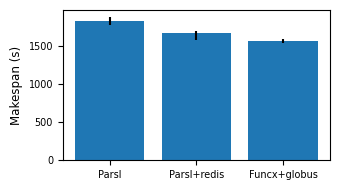

In [4]:
spans = dict((k, get_training_spans(v)) for k, v in runs.items())
fig, ax = plt.subplots(figsize=(3.5, 2.))

medians = [np.median(v) for v in spans.values()]
errors = np.abs([np.percentile(v, [40, 60]) - np.median(v) for v in spans.values()])
print(dict(zip(spans.keys(), medians)))
ax.bar(range(len(spans)), medians, yerr=errors.T)

ax.set_xticks(range(len(spans)))
ax.set_xticklabels(map(str.capitalize, runs))
print(dict(zip(spans.keys(), errors)))

ax.set_ylabel('Makespan (s)')
fig.tight_layout()
fig.savefig('figures/parsl-comparision_training-responsiveness.png', dpi=320)
fig.savefig('figures/parsl-comparision_training-responsiveness.pdf')

*Finding*: Better performance the more SSH tunnels we use, with a big caveat: Parsl without ProxyStore suffers large performance problems.

## Plot time between worker finishing work and getting next
See how well we are keeping the simulation utilized

In [5]:
def get_idle_times(run_path: Path) -> np.ndarray:
    """Get the lengths of time a QC worker sits idle 
    
    Args:
        path: Path to the run
    Returns:
        Length of time workers sat idle
    """
    
    # Prepare storage 
    output = []
    
    # Loop over all duplicates
    repeats = map(Path, json.loads((run_path / 'duplicates.json').read_text()))
    
    for path in repeats:
        # Load in the simulation records
        try:
            results = pd.read_json(path / 'simulation-results.json', lines=True)
        except Exception as e:
            raise ValueError(f'Failed to read {path}') from e

        # Get the hostname for the worker
        results['hostname'] = results['worker_info'].apply(lambda x: x.get('hostname') if x is not None else None)
        results = results[~ results['hostname'].isnull()]

        # Compute the time a job finished
        results['time_compute_finished'] = results['time_compute_started'] + results['time_running']

        # Collect the idle times
        idle_times = []
        for host, group in results.sort_values('time_compute_started').groupby('hostname'):
            # It is the time between when a worker started a task and the previous one finished
            my_idle = group['time_compute_started'].iloc[1:].values - group['time_compute_finished'].values[:len(group)-1]
            idle_times.extend(my_idle)

        idle_times = [x for x in idle_times if x < 60.]  # >30 means the workers are in different jobs (i.e., stop and started in between)

        # Add to the total output
        output.extend(idle_times)
        
    return np.array(idle_times)

In [6]:
def get_comm_times(path: Path) -> pd.DataFrame:
    """Get the times to communicate results between each of the workers servers"""
    
    try:
        results = pd.read_json(path / 'simulation-results.json', lines=True)
    except Exception as e:
        raise ValueError(f'Failed to read {path}') from e
    
    # Get the time a result finished
    results['time_compute_finished'] = results['time_compute_started'] + results['time_running']
    
    # Get the time between when a result was completed and recieved by Parsl
    results['result_comm_time'] = results['time_result_sent'] - results['time_compute_finished']
    results['request_comm_time'] = results['time_compute_started'] - results['time_input_received']
    
    return results[['result_comm_time', 'request_comm_time']]

{'Parsl': 0.13731884956359863, 'Parsl+Redis': 0.09779047966003418, 'FuncX+Globus': 0.5533355474472046}
{'Parsl': array([0.03015099, 0.08669677]), 'Parsl+Redis': array([0.0100986 , 0.01003504]), 'FuncX+Globus': array([0.04910772, 0.07169998])}


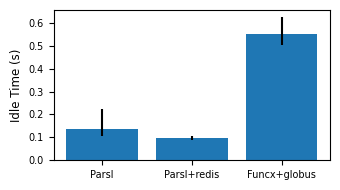

In [7]:
spans = dict((k, get_idle_times(v)) for k, v in runs.items())
fig, ax = plt.subplots(figsize=(3.5, 2.))

medians = [np.median(v) for v in spans.values()]
errors = np.abs([np.percentile(v, [40, 60]) - np.median(v) for v in spans.values()])
print(dict(zip(spans.keys(), medians)))
print(dict(zip(spans.keys(), errors)))
ax.bar(range(len(spans)), medians, yerr=errors.T)

ax.set_xticks(range(len(spans)))
ax.set_xticklabels(map(str.capitalize, runs))

ax.set_ylabel('Idle Time (s)')
fig.tight_layout()
fig.savefig('figures/parsl-comparision_simulator-downtime.png', dpi=320)
fig.savefig('figures/parsl-comparision_simulator-downtime.pdf')

Get how long a typical task is

In [8]:
pd.read_json(runs['FuncX+Globus'] / 'simulation-results.json', lines=True).query('success').time_running.describe()

count    520.000000
mean      86.380591
std       47.726787
min       17.571616
25%       52.673317
50%       76.664486
75%      108.515462
max      278.974473
Name: time_running, dtype: float64

*Finding*: FuncX is slower but more consistant than pure Parsl (likely some contention issues with tasks taking a long time to send). 

### Make a composite plot
We are going to show simulation uptime and ML makespan in the same chart

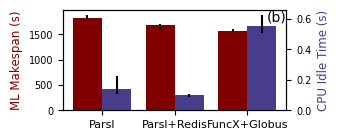

In [9]:
fig, ax = plt.subplots(figsize=(3.5, 1.5))

ax.text(1, 1, '(b)', ha='right', va='top', transform=ax.transAxes)

# Plot the ML makespan
spans = dict((k, get_training_spans(v)) for k, v in runs.items())
medians = [np.median(v) for v in spans.values()]
errors = np.abs([np.percentile(v, [40, 60]) - np.median(v) for v in spans.values()])
ax.bar(np.arange(len(spans)) - 0.4, medians, yerr=errors.T, color='maroon', width=0.4, align='edge')

ax.set_ylabel('ML Makespan (s)', color='maroon')

# Plot the QC idletime
ax2 = ax.twinx()
spans = dict((k, get_idle_times(v)) for k, v in runs.items())
medians = [np.median(v) for v in spans.values()]
errors = np.abs([np.percentile(v, [40, 60]) - np.median(v) for v in spans.values()])
ax2.bar(range(len(spans)), medians, yerr=errors.T, color='darkslateblue', width=0.4, align='edge')

ax2.set_ylabel('CPU Idle Time (s)', color='darkslateblue')

ax.set_xticks(range(len(spans)))
ax.set_xticklabels(runs, fontsize=8)

fig.tight_layout()
fig.savefig('figures/parsl-comparision_latencies.png', dpi=320)
fig.savefig('figures/parsl-comparision_latencies.pdf')

## Plot the Performance over Time
See which approach gives better science results

In [10]:
def get_simulation_outcome(path) -> pd.DataFrame:
    """Get the IP count as a function of node hours expended
    
    Args:
        path: Path to the run directory
    Returns:
        Dataframe with at least a few columns:
            - `nodehours_used`: Number of node hours consume by the workflow
            - `mols_found`: Number of molecules found with an IP above 14
    """
    
    # Read the simulation runs
    data = pd.read_json(path / 'simulation-results.json', lines=True).sort_values('time_created').query('success')
    data['ip'] = data['task_info'].apply(lambda x: x['ip']['xtb-vacuum'])
    
    # Count the number of nodes available at any moment
    changes = list(zip(data['time_compute_started'], repeat(1), repeat(0)))
    changes.extend(zip(data['time_compute_started'] + data['time_running'], repeat(-1), (data['ip'] > 14).map(int)))
    changes = sorted(changes, key=lambda x: x[0])
    
    # Add them together into an output dataframe
    changes = pd.DataFrame(changes, columns=['walltime', 'node_changes', 'new_found'])
    changes['walltime'] -= changes['walltime'].min()
    
    # Compute current utilization and number found
    changes['num_found'] = changes['new_found'].cumsum()
    changes['active_nodes'] = changes['node_changes'].cumsum()
    
    # Compute the node hours used, factoring out when the system was in queue
    #  Method: Count all nodes being used if any task is active during a time interval
    max_nodes = changes['active_nodes'].max()
    last_segment_active = changes['active_nodes'].iloc[0:-1] > 1
    walltime_usage = np.diff(changes['walltime']) * last_segment_active * max_nodes
    changes['node_hours_used'] = [0] + np.cumsum(walltime_usage).tolist()
    changes['node_hours_used'] /= 3600
    
    return changes

Parsl finds 137.3 after 6 node-hours: 127 141 144
Parsl+Redis finds 140.3 after 6 node-hours: 149 129 143
FuncX+Globus finds 145.0 after 6 node-hours: 143 143 149


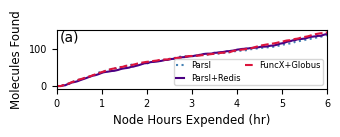

In [27]:
fig, ax = plt.subplots(figsize=(3.5, 1.3))

ax.text(0.01, 0.99, '(a)', ha='left', va='top', transform=ax.transAxes)

colors = {
    'Parsl': 'steelblue',
    'FuncX+Globus': 'crimson',
    'Parsl+Redis': 'indigo'
}

length = 6
for (name, run_path), ls in zip(runs.items(), [':', '-', '--']):
    # Make an interpolator for the trajectory for each duplicate run
    # Loop over all duplicates
    repeats = map(Path, json.loads((run_path / 'duplicates.json').read_text()))
    interps = []
    for path in repeats:
        data = get_simulation_outcome(path)
        assert data['node_hours_used'].max() > length, f'Run not yet finished. {path.name}. Only used {data.node_hours_used.max():.2f}'
        interps.append(
            interp1d(data['node_hours_used'], data['num_found'], kind='previous')
        )
        
    # Plot the mean over the runs
    points = np.linspace(0, length, 128)
    scores = [i(points) for i in interps]
    counts = [i(length) for i in interps]
    score = np.mean(counts, axis=0)
    print(f'{name} finds {np.mean([i(length) for i in interps]):.1f} after {length} node-hours: '
          + " ".join(f"{x:.0f}" for x in counts))
    
    ax.plot(points, np.mean(scores, axis=0), color=colors[name], linestyle=ls, label=name)
    
# Plot the baseline
#data = get_simulation_outcome(Path('./prod-runs/8KNL-8V100-no-retrain/'))
#ax.plot(data['node_hours_used'], data['num_found'], 'k--', label='Baseline')

ax.set_xlim(0, length)
    
ax.legend(loc='lower right', ncol=2, fontsize=6, handlelength=1, borderpad=0.2, columnspacing=0.5)
ax.set_xlabel('Node Hours Expended (hr)')
ax.set_ylabel('Molecules Found')

fig.tight_layout()
fig.savefig('figures/parsl-comparision_active-learning-performance.png', dpi=320)
fig.savefig('figures/parsl-comparision_active-learning-performance.pdf')

Moving to FuncX doesn't harm our scientific outcomes significnatly.